# Galletas evolved: La moneda de 1 euro

Una declaración estadística apareció en The Guardian el viernes 4 de enero de 2002:

Cuando se giró de canto 250 veces, una moneda belga de 1 euro salió cara 140 veces y cruz 110 veces. "Me parece muy sospechoso", dijo Barry Blight, profesor de estadística en la London School of Economics. "Si la moneda no estuviera sesgada, la probabilidad de obtener un resultado tan extremo sería menos del 7%".

Pero **¿estos datos dan suficiente evidencia de que la moneda está sesgada en lugar de ser justa?**

Para responder a esa pregunta, procederemos en dos pasos. Primero usaremos la distribución binomial para ver de dónde proviene ese 7%; luego utilizaremos el Teorema de Bayes para estimar la probabilidad de que esta moneda salga cara.

In [89]:
from scipy.stats import binom

n = 2
p = 0.5
k = 1

binom.pmf(k, n, p)

0.5000000000000002

In [90]:
import numpy as np

ks = np.arange(n+1)

ps = binom.pmf(ks, n, p)
ps

array([0.25, 0.5 , 0.25])

In [91]:
from empiricaldist import Pmf

pmf_k = Pmf(ps, ks)
pmf_k

,probs
0,0.25
1,0.50
2,0.25


In [92]:
def make_binomial(n, p):
    """Make a binomial Pmf."""
    ks = np.arange(n+1)
    ps = binom.pmf(ks, n, p)
    return Pmf(ps, ks)

In [94]:
pmf_k = make_binomial(n=250, p=0.5)

<Axes: title={'center': 'FMP Binomial'}>

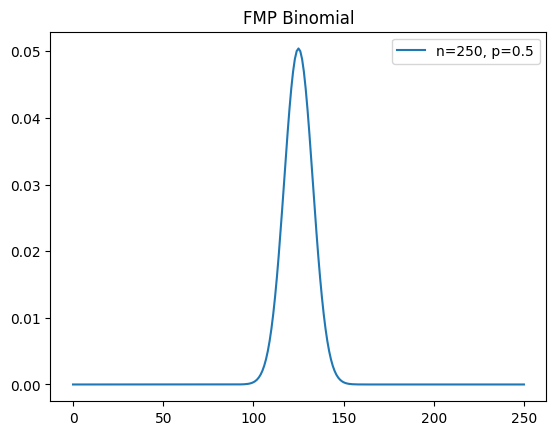

In [131]:
pmf_k.plot(label='n=250, p=0.5', title='FMP Binomial', legend='true')

In [117]:
pmf_k.max_prob()

125

In [118]:
pmf_k[125]

0.050412213147309655

In [119]:
def prob_ge(pmf, threshold):
    """Probability of quantities greater than threshold."""
    ge = (pmf.qs >= threshold)
    total = pmf[ge].sum()
    return total

In [120]:
prob_ge(pmf_k, 140)

0.03321057562002166

In [121]:
pmf_k.prob_ge(140)

0.03321057562002166

<Axes: title={'center': 'FMP Binomial'}>

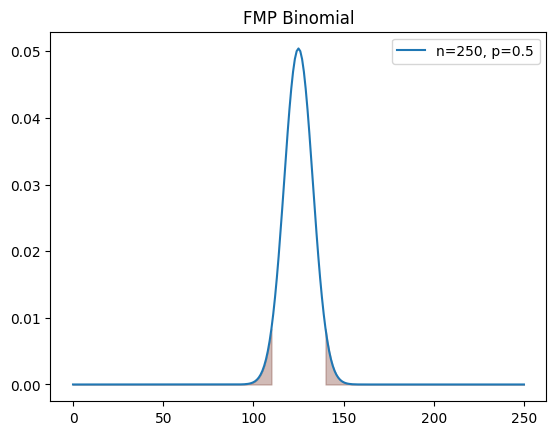

In [132]:
import matplotlib.pyplot as plt

def fill_below(pmf):
    qs = pmf.index
    ps = pmf.values
    plt.fill_between(qs, ps, 0, color='C5', alpha=0.4)

qs = pmf_k.index
fill_below(pmf_k[qs>=140])
fill_below(pmf_k[qs<=110])
pmf_k.plot(label='n=250, p=0.5', title='FMP Binomial', legend='true')

In [123]:
pmf_k.prob_le(110)

0.033210575620021665

De sumar estos .033, obtenemos el 7%.

## Estimación Bayesiana


Cualquier moneda tiene una cierta probabilidad de caer con la cara hacia arriba cuando se hace girar sobre su borde; llamaremos a esta probabilidad x. Parece razonable creer que x depende de las características físicas de la moneda, como la distribución del peso. Si una moneda está perfectamente equilibrada, esperamos que x esté cerca del 50%, pero para una moneda desequilibrada, x podría ser sustancialmente diferente. Podemos usar el teorema de Bayes y los datos observados para estimar x.








In [124]:
hypos = np.linspace(0, 1, 101)
prior = Pmf(1, hypos)

In [125]:
likelihood_heads = hypos
likelihood_tails = 1 - hypos

In [106]:
likelihood = {
    'H': likelihood_heads,
    'T': likelihood_tails
}

In [107]:
dataset = 'H' * 140 + 'T' * 110

In [126]:
def update_euro(pmf, dataset):
    """Update pmf with a given sequence of H and T."""
    for data in dataset:
        pmf *= likelihood[data]

    pmf.normalize()

In [127]:
posterior = prior.copy()
update_euro(posterior, dataset)

<Axes: title={'center': 'Distribución posterior'}>

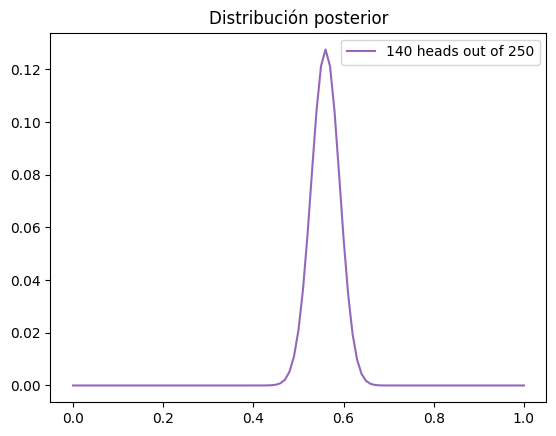

In [133]:
posterior.plot(label='140 heads out of 250', color='C4', legend=True, title='Distribución posterior')

In [112]:
posterior.max_prob()

0.56

Notar que 140/250 = .56

¿Que pasaría si utilizaramos un prior que no fuera la distribución uniforme?

# Priors Conjugados o Conjugate Priors

Existe una manera más sencilla de realizar actualizaciones bayesianas.

Cuando las distribuciones prior y posterior pertenecen a la misma familia de distribuciones de probabilidad, la distribución prior se llama una prior conjugado a la función de verosimilitud.

Esta propiedad simplifica el proceso de actualizar creencias en presencia de nuevos datos, ya que asegura que la distribución posterior esté en la misma familia que la distribución previa.

In [41]:
!pip install empiricaldist

In [42]:
from empiricaldist import Pmf

def pmf_from_dist(dist, low, high):
    """Make a discrete approximation of a continuous distribution.

    dist: SciPy dist object
    low: low end of range
    high: high end of range

    returns: normalized Pmf
    """
    qs = np.linspace(low, high, 101)
    ps = dist.pdf(qs)
    pmf = Pmf(ps, qs)
    pmf.normalize()
    return pmf

## Gamma y Poisson

La distribución Gamma es el prior conjugate de la distribución Poisson

Esto nos va a dar una manera muy sencilla de obtener la distribución posterior

In [43]:
from scipy.stats import gamma
from scipy.stats import poisson
import numpy as np

In [44]:
def make_gamma_dist(alpha, beta):
    """Makes a gamma object."""
    dist = gamma(alpha, scale=1/beta)
    dist.alpha = alpha
    dist.beta = beta
    return dist

In [45]:
alpha = 1.4
beta = 1

prior_gamma = make_gamma_dist(alpha, beta)
prior_gamma.mean()

1.4

Afirmamos sin demostrar que podemos hacer una actualización bayesiana de k goles/galletas/spins simplemente creando una distribución gamma con parámetros alfa+k y beta+1.

In [46]:
def update_gamma(prior, data):
    """Update a gamma prior."""
    k, t = data
    alpha = prior.alpha + k
    beta = prior.beta + t
    return make_gamma_dist(alpha, beta)

Por ejemplo, para 4 goles en 1 partido:

In [135]:
data = 4, 1
posterior_gamma = update_gamma(prior_gamma, data)

In [136]:
#lams = np.linspace(0, 10, 101)
posterior_conjugate = pmf_from_dist(posterior_gamma, 0, 10)

<Axes: >

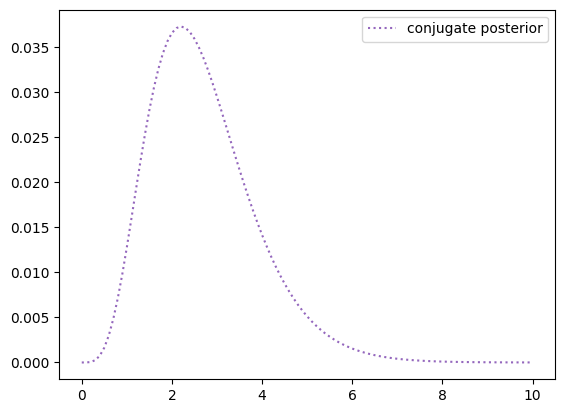

In [137]:
posterior_conjugate.plot(label='conjugate posterior',
                         color='C4', ls=':', legend=True)

## Binomial y Beta

La distribución beta es el prior conjugado de la distribución binomial

De hecho, la distribución uniforme es una instancia de la distribución beta cuando sus parámetros son igual a 1

In [50]:
import scipy.stats

def make_beta(alpha, beta):
    """Makes a beta object."""
    dist = scipy.stats.beta(alpha, beta)
    dist.alpha = alpha
    dist.beta = beta
    return dist

La distribución beta está limitada entre 0 y 1, por lo que funciona bien para representar la distribución de una probabilidad como x. Tiene dos parámetros, llamados alfa y beta, que determinan la forma de la distribución.








In [51]:
alpha = 1
beta = 1

prior_beta = make_beta(alpha, beta) # Beta/Uniforme

En este caso, la actualización bayesiana se reduce a sumar $k$ y $n-k$ en alfa y beta respectivamente.

In [52]:
def update_beta(prior, data):
    """Update a beta distribution."""
    k, n = data
    alpha = prior.alpha + k
    beta = prior.beta + n - k
    return make_beta(alpha, beta)

In [53]:
data = 140, 250
posterior_beta = update_beta(prior_beta, data)

In [54]:
posterior_conjugate = pmf_from_dist(posterior_beta, 0, 1)

<Axes: >

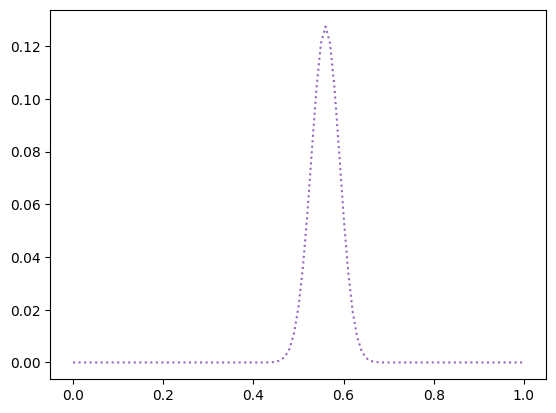

In [55]:
posterior_conjugate.plot(label='conjugate posterior',
                        color='C4', ls=':')

## Multinomial y Dirichlet

Supongamos que visitamos una reserva de animales salvajes donde sabemos que los únicos animales son leones, tigres y osos, pero no sabemos cuántos hay de cada uno. Durante el recorrido, vemos 3 leones, 2 tigres y 1 oso. Suponiendo que cada animal tenía igual probabilidad de aparecer en nuestra muestra, ¿cuál es la probabilidad de que el próximo animal que veamos sea un oso?

Para responder a esta pregunta, utilizaremos los datos para estimar la prevalencia de cada especie, es decir, qué fracción de los animales pertenece a cada especie. Si conocemos las prevalencias, podemos usar la distribución multinomial para calcular la probabilidad de los datos. Por ejemplo, supongamos que sabemos que la fracción de leones, tigres y osos es 0.4, 0.3 y 0.3, respectivamente.

In [56]:
from scipy.stats import multinomial

data = 3, 2, 1
n = np.sum(data)
ps = 0.4, 0.3, 0.3

multinomial.pmf(data, n, ps)

0.10368

Ahora podríamos elegir un prior para las prevalencias y hacer una actualización bayesiana usando la distribución multinomial para calcular la probabilidad de los datos.

Pero hay una manera más fácil, porque la distribución multinomial tiene un prior conjugado: la distribución de Dirichlet.

In [57]:
from scipy.stats import dirichlet

alpha = 1, 2, 3
dist = dirichlet(alpha)

In [58]:
dist.rvs()

array([[0.05147568, 0.39042444, 0.55809988]])

In [59]:
dist.rvs().sum()

1.0

In [60]:
sample = dist.rvs(1000)

In [61]:
sample.shape

(1000, 3)

In [62]:
from empiricaldist import Cdf

cdfs = [Cdf.from_seq(col)
        for col in sample.transpose()]

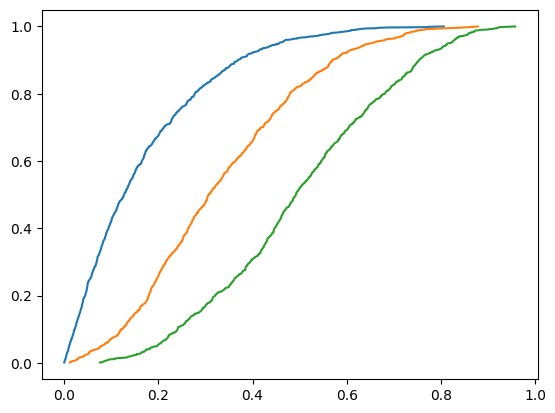

In [63]:
for i, cdf in enumerate(cdfs):
    label = f'Column {i}'
    cdf.plot(label=label)


Resulta que estas distribuciones marginales son distribuciones beta. La siguiente función toma una secuencia de parámetros, alpha, y calcula la distribución marginal de la variable i:

In [64]:
def marginal_beta(alpha, i):
    """Compute the ith marginal of a Dirichlet distribution."""
    total = np.sum(alpha)
    return make_beta(alpha[i], total-alpha[i])

In [65]:
marginals = [marginal_beta(alpha, i)
             for i in range(len(alpha))]

Comparamos las marginales obtenidas de los datos contra las marginales teóricas:

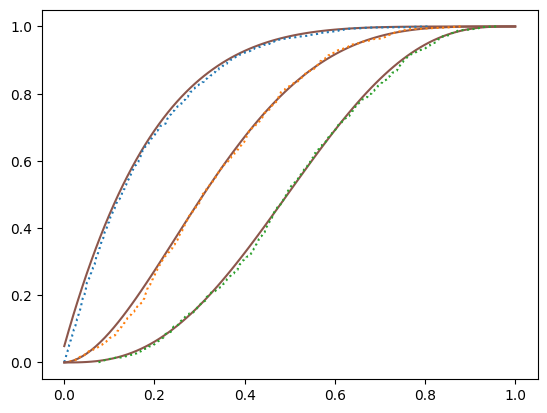

In [66]:
xs = np.linspace(0, 1, 101)

for i in range(len(alpha)):
    label = f'Column {i}'

    pmf = pmf_from_dist(marginals[i], 0, 1)
    pmf.make_cdf().plot(color='C5')

    cdf = cdfs[i]
    cdf.plot(label=label, ls=':')

De donde obtenemos confirmación visual de que las distribuciones marginales de una distribucipon de Dirichlet (multivariada) son efectivamente distribuciones Beta.

Así, podemos contestar la pregunta ayudándonos de los priors conjugados:

In [138]:
prior_alpha = np.array([1, 1, 1]) # alpha para el prior (Dirichlet)
data = 3, 2, 1

In [141]:
posterior_alpha = prior_alpha + data # La actualización es una suma en alpha
posterior_alpha

array([4, 3, 2])

In [75]:
marginal_bear = marginal_beta(posterior_alpha, 2) # Visto marginalmente
marginal_bear.mean()

0.2222222222222222

In [142]:
dist = dirichlet(posterior_alpha) # Visto conjuntamente

In [143]:
import pandas as pd

index = ['lion', 'tiger', 'bear']
pd.DataFrame(dist.mean(), index, columns=['prob'])

,prob
lion,0.444444
tiger,0.333333
bear,0.222222


## Los reviewers de 3Blue1Brown

3Blue1Brown plante el siguiente problema en uno de sus videos:

> Estás comprando un producto en línea y ves que tres vendedores ofrecen el mismo producto al mismo precio. Uno de ellos tiene una calificación positiva del 100%, pero con solo 10 reseñas. Otro tiene una calificación positiva del 96% con un total de 50 reseñas. Y otro más tiene una calificación positiva del 93%, pero con 200 reseñas en total.

> ¿De cuál vendedor deberías comprar?








Supongamos que cada vendedor tiene una probabilidad desconocida x de proporcionar un servicio satisfactorio y obtener una calificación positiva, y queremos elegir al vendedor con el valor más alto de x.

<Axes: >

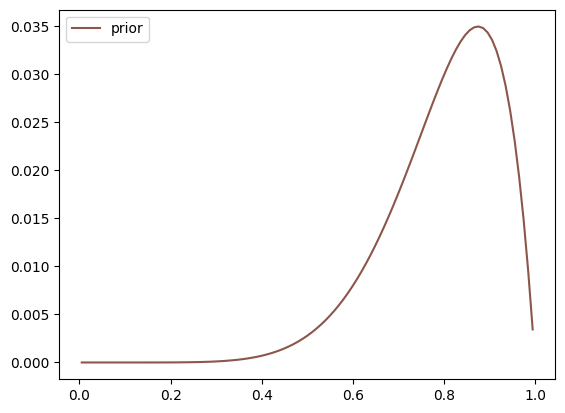

In [145]:
# Utilicemos un beta de prior con parámetros 8 y 2
# De esta forma, estamos suponiendo que los vendedores son buenos la mayoría de las veces

prior = make_beta(8, 2)

prior_pmf = pmf_from_dist(prior, .005, .995)
prior_pmf.plot(color='C5', label='prior', legend=True)

In [154]:
# Datos
data1 = 10, 10 # --> 100%
data2 = 48, 50 # --> 96%
data3 = 186, 200 # --> 93%

In [147]:
# Actualización
seller1 = update_beta(prior, data1)
seller2 = update_beta(prior, data2)
seller3 = update_beta(prior, data3)

In [148]:
seller1_pmf = pmf_from_dist(seller1, .005, .995)
seller2_pmf = pmf_from_dist(seller2, .005, .995)
seller3_pmf = pmf_from_dist(seller3, .005, .995)

<Axes: >

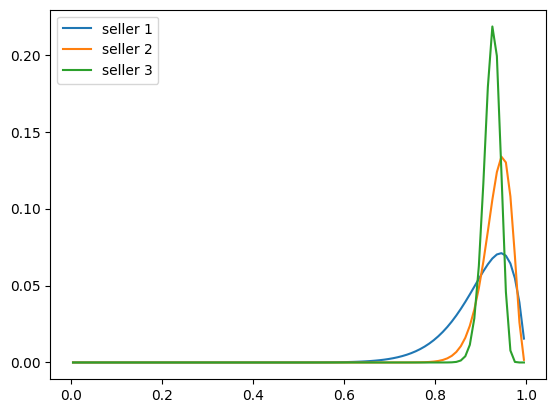

In [150]:
seller1_pmf.plot(label='seller 1', legend=True)
seller2_pmf.plot(label='seller 2', legend=True)
seller3_pmf.plot(label='seller 3', legend=True)

In [151]:
seller1.mean(), seller2.mean(), seller3.mean()

(0.9, 0.9333333333333333, 0.9238095238095239)